# External validation

In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np
import xarray
import rioxarray
import rasterstats
import matplotlib.pyplot as plt
from xrspatial.zonal import crosstab
from itertools import product
import tobler
import dask_geopandas


from download import download
from geocube.api.core import make_geocube

In [2]:
def cramers_v(confusion_matrix):
    chi2 = sp.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## WorldPop urban classification

Download and read data.

In [4]:
soton_path = download("https://eprints.soton.ac.uk/446482/1/GB_100m_mbclust6_3x3maj.tif",
                      '../../urbangrammar_samba/spatial_signatures/validation/B_100m_mbclust6_3x3maj.tif')


file_sizes: 100%|██████████████████████████| 2.79M/2.79M [00:00<00:00, 9.87MB/s]
Successfully downloaded file to ../../urbangrammar_samba/spatial_signatures/validation/B_100m_mbclust6_3x3maj.tif


In [3]:
soton = rioxarray.open_rasterio("../../urbangrammar_samba/spatial_signatures/validation/B_100m_mbclust6_3x3maj.tif")

In [2]:
signatures = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_simplified.pq")

Reproject.

In [8]:
soton.rio.crs

CRS.from_wkt('PROJCS["Airy_1830_Transverse_Mercator",GEOGCS["Unknown datum based upon the Airy 1830 ellipsoid",DATUM["unknown",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [4]:
soton_osgb = soton.rio.reproject("EPSG:27700")

Get signature type as float.

In [23]:
signatures.signature_type = (signatures.kmeans10gb * 10) + signatures.level2
signatures

,kmeans10gb,geometry,level2,signature_type
0,0,"POLYGON ((62219.999 798499.999, 62109.999 7985...",0.0,0.0
1,0,"POLYGON ((63507.682 796515.168, 63471.096 7965...",0.0,0.0
2,0,"POLYGON ((65953.174 802246.171, 65523.864 8023...",0.0,0.0
3,0,"POLYGON ((67297.740 803435.799, 67220.290 8034...",0.0,0.0
4,0,"POLYGON ((75760.000 852669.999, 75699.999 8527...",0.0,0.0
...,...,...,...,...
96699,9,"POLYGON ((323321.005 463795.415, 323236.741 46...",8.0,98.0
96700,9,"POLYGON ((325929.840 1008792.060, 325890.989 1...",8.0,98.0
96701,9,"POLYGON ((337804.769 1013422.582, 337547.855 1...",8.0,98.0
96702,9,"POLYGON ((422304.270 1147826.989, 422296.000 1...",8.0,98.0


Rasterise signatures.

In [24]:
%%time
signatures_raster = make_geocube(signatures, measurements=["signature_type"], like=soton_osgb)

CPU times: user 19.5 s, sys: 592 ms, total: 20.1 s
Wall time: 20 s


Save raster to file.

In [48]:
signatures_raster.signature_type.rio.to_raster("signatures_raster.tif")

Create cross tabulation. There may be a smarter way but this one works. 

In [97]:
spsig_vals = signatures.signature_type.unique()
soton_vals = [1, 2, 3, 4, 5, 6, 15]
crosstab = pd.DataFrame(columns=soton_vals, index=spsig_vals)

for sp, so in product(spsig_vals, soton_vals):
    crosstab.loc[sp, so] =  np.logical_and(signatures_raster.signature_type == sp, soton_osgb[0] == so).data.sum()

In [102]:
crosstab

,1,2,3,4,5,6,15
0.0,245644,261108,92204,63004,28364,72865,8622602
10.0,168,322,106061,31752,2523,52230,31393
30.0,2192,2879,118522,73965,20202,102378,187853
40.0,86139,72260,3923,5522,5364,5755,8951880
50.0,1714,1596,10016,47775,25739,42455,116893
60.0,2,3,2845,10010,937,10284,2044
70.0,62430,77909,214575,92106,35194,116073,2560377
80.0,5,42,18644,16477,1089,30128,4621
20.0,35,50,3052,37679,8640,30630,15670
21.0,46,35,5140,18442,2334,22985,7508


Plot percentages.

<AxesSubplot:>

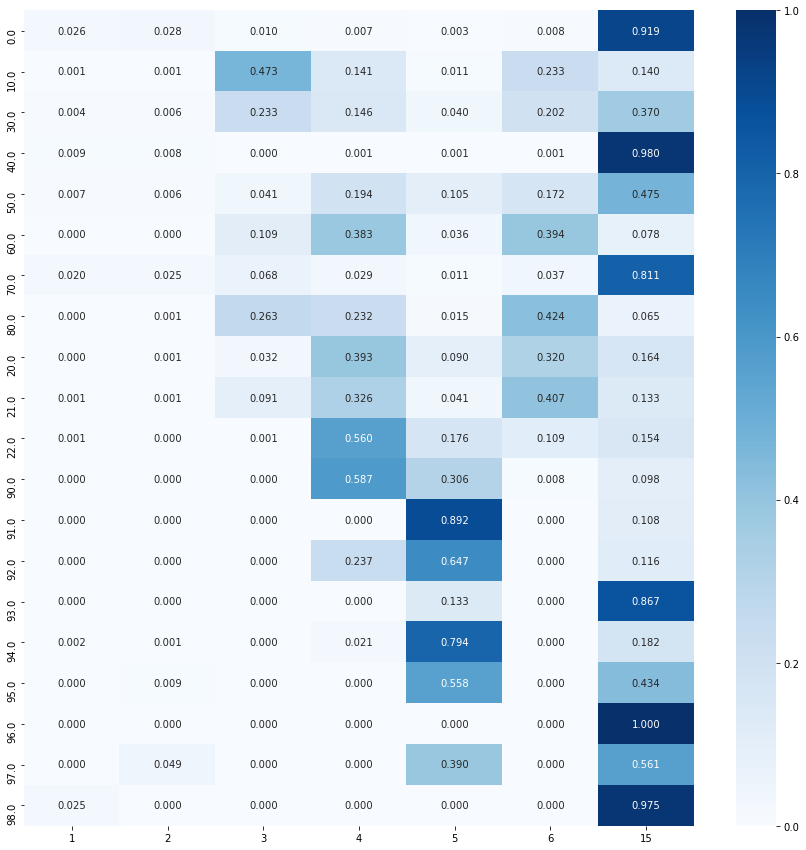

In [108]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(crosstab.divide(crosstab.sum(axis=1), axis=0).astype('float'), cmap="Blues", annot=True, fmt='.3f',)

Compute Cramer's V.

In [109]:
cramers_v(crosstab)

0.3109737978543489

Results indicate moderate associtation.

## MODUM

Load MODUM data (manually downloaded from CDRC).

In [2]:
modum = gpd.read_file("../../urbangrammar_samba/spatial_signatures/validation/modumew2016.zip")

In [11]:
modum

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,OA_CODE,LAD_NAME,REGION_NAM,CLUSTER_CO,CLUSTER_LA,geometry
0,E00044639,Sunderland,North East,5,Waterside Settings,"POLYGON ((440611.474 558272.251, 440527.700 55..."
1,E00036646,Wirral,North West,4,Victorian Terraces,"POLYGON ((330917.000 394161.000, 330937.346 39..."
2,E00092449,Cheshire West and Chester,North West,5,Waterside Settings,"POLYGON ((339836.566 367010.434, 339864.000 36..."
3,E00044638,Sunderland,North East,8,Central Business District,"POLYGON ((440006.000 558293.000, 440091.001 55..."
4,E00094441,Cheshire West and Chester,North West,1,Suburban Landscapes,"POLYGON ((364937.770 373630.624, 364860.312 37..."
...,...,...,...,...,...,...
181403,E00175248,Westminster,London,8,Central Business District,"POLYGON ((529580.098 179194.237, 529586.108 17..."
181404,E00169799,Leeds,Yorkshire and The Humber,8,Central Business District,"POLYGON ((428969.394 433302.516, 428964.400 43..."
181405,E00115865,Gosport,South East,5,Waterside Settings,"POLYGON ((461450.326 98059.723, 461404.687 981..."
181406,E00175716,Birmingham,West Midlands,8,Central Business District,"POLYGON ((406120.776 286455.941, 406119.217 28..."


Load ET celss with signature type label as Dask GeoDataFrame.

In [26]:
cells = dask_geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_tessellation/")
cells

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hindex,geometry,signature_type
npartitions=103,,,
,object,geometry,int32
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


Interpolate MODUM classes to ET cells.

In [30]:
def _join_modum(ch):
    tb = ch.total_bounds
    modum_ch = modum.cx[tb[0]:tb[2], tb[1]:tb[3]]
    return tobler.area_weighted.area_join(modum_ch, ch, ["CLUSTER_CO"])

meta = tobler.area_weighted.area_join(modum, cells._meta, ["CLUSTER_CO"])

modum_joined = cells.map_partitions(_join_modum, meta=meta)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  if (await self.run_code(code, result,  async_=asy)):


Select only subset of data needed for crosstab.

In [31]:
modum_data = modum_joined[["signature_type", "CLUSTER_CO"]]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Compute Dask-based steps.

In [32]:
%%time
modum_data = modum_data.compute()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/tobler/area_weighted/area_join.py:63: UserWarning: Cannot preserve dtype of 'CLUSTER_CO'. Falling back to `dtype=object`.
  warnings.warn(


CPU times: user 2h 38min 50s, sys: 20min 41s, total: 2h 59min 31s
Wall time: 38min 10s


In [33]:
modum_data

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,signature_type,CLUSTER_CO
0,6,3
1,6,3
2,6,3
3,6,3
4,6,3
...,...,...
139305,0,6
139306,0,6
139307,0,6
139308,0,6


Generate cross tabulation

In [34]:
crosstab = pd.crosstab(modum_data.signature_type, modum_data.CLUSTER_CO)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
crosstab

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CLUSTER_CO,1,2,3,4,5,6,7,8
signature_type,,,,,,,,
0,69795,15802,4221,23472,182137,2476766,17319,368
1,965634,77081,4747,132642,74036,496728,35341,18402
3,732427,134316,31433,321086,269592,743994,80637,25704
4,530,179,5,275,8875,323286,66,62
5,181327,41638,4315,154154,74066,141490,21848,13472
6,55918,14731,6579,80570,9560,7671,7728,18096
7,518434,100597,27825,171963,341933,2075046,80646,6225
8,210331,30133,11048,157174,36122,68072,16956,15258
20,98914,59058,12731,147608,37505,17095,24222,57099


Plot percentages.


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='CLUSTER_CO', ylabel='signature_type'>

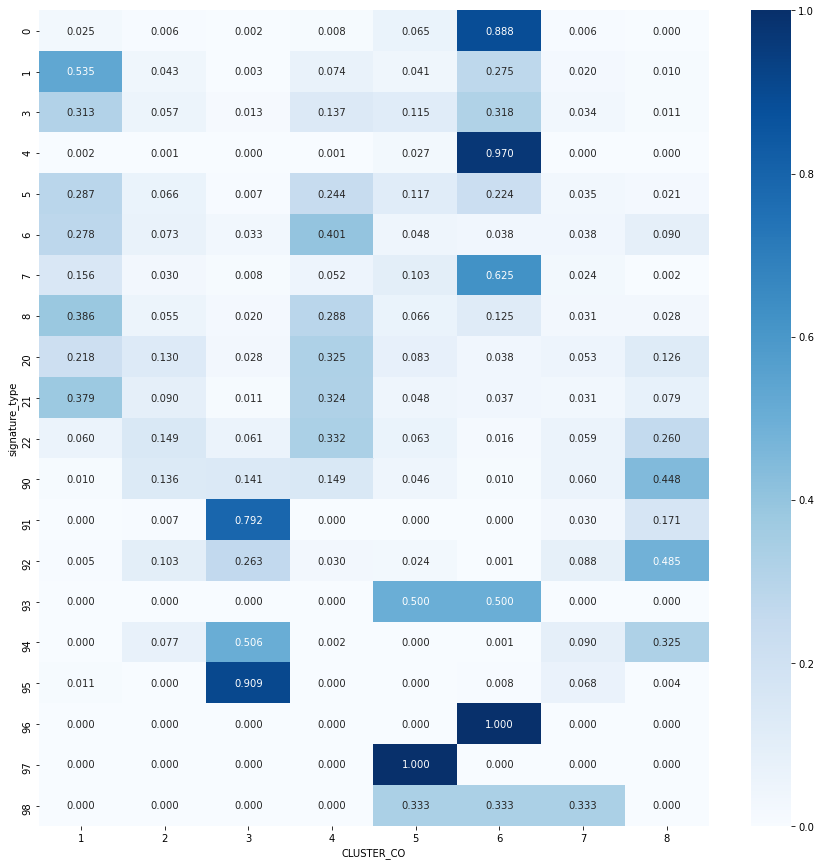

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(crosstab.divide(crosstab.sum(axis=1), axis=0).astype('float'), cmap="Blues", annot=True, fmt='.3f',)

Compute Cramer's V.

In [38]:
cramers_v(crosstab)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.3007137152411417

Results indicate moderate associtation.

## Urban Atlas

Link is no longer valid and needs to be generated at https://land.copernicus.eu/local/urban-atlas/urban-atlas-2018/. The zip contains the full UK classification.

In [39]:
urban_atlas_path = download("https://land.copernicus.eu/land-files/f0dd642f9db5ca4de46b3cc955de135503446c43.zip",
                      '../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/', kind="zip")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating data folder...

file_sizes: 100%|██████████████████████████| 2.68G/2.68G [00:42<00:00, 63.5MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/


In [4]:
urban_atlas_path = '../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/'

In [5]:
import zipfile
from glob import glob

# zip file handler  
a = zipfile.ZipFile(glob(urban_atlas_path + '*')[0])

In [6]:
a.namelist()

['UK566L1_NORWICH_UA2018_v012/Data/UK566L1_NORWICH_UA2018_v012.gpkg',
 'UK566L1_NORWICH_UA2018_v012/Metadata/UK566L1_NORWICH_UA2018_v012.xml',
 'UK566L1_NORWICH_UA2018_v012/Legend/Urban_Atlas_2018_Legend.lyr',
 'UK566L1_NORWICH_UA2018_v012/Legend/Urban_Atlas_2018_Legend.qml',
 'UK566L1_NORWICH_UA2018_v012/Legend/Urban_Atlas_2018_Legend.sld',
 'UK566L1_NORWICH_UA2018_v012/Documents/UK566L1_NORWICH_UA2018_DELIVERY_REPORT.pdf',
 'UK566L1_NORWICH_UA2018_v012/Documents/UK566L1_NORWICH_UA2018_MAP.pdf']

In [7]:
fuas = []

for file in glob(urban_atlas_path + '*'):
    a = zipfile.ZipFile(file)
    gdf = gpd.read_file(file + "!" + a.namelist()[0])
    fuas.append(gdf)
    print(file)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK566L1_NORWICH_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK002L3_WEST_MIDLANDS_URBAN_AREA_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK562L2_PRESTON_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK009L1_CARDIFF_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK517L1_SWANSEA_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK026L1_KINGSTON_UPON_HULL_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK056L1_HASTINGS_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK539L1_BOURNEMOUTH_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK033L1_GUILDFORD_UA2018_v012.zip
../../urbangrammar_samba/spatial_signatures/validation/urban_atlas/UK023L1

In [8]:
urban_atlas = pd.concat(fuas)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
urban_atlas.crs

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terr

In [9]:
urban_atlas = urban_atlas.to_crs(27700)

In [15]:
urban_atlas = urban_atlas[urban_atlas.class_2018 != "Other roads and associated land"]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
urban_atlas

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,geometry
0,UK,Norwich,UK566L1,12100,"Industrial, commercial, public, military and p...",2020-02,6191-UK566L1,395.405063,9578.604245,None,"MULTIPOLYGON (((620644.028 307123.158, 620624...."
1,UK,Norwich,UK566L1,12100,"Industrial, commercial, public, military and p...",2020-02,6276-UK566L1,344.502008,5999.177060,None,"MULTIPOLYGON (((625449.063 309572.394, 625436...."
2,UK,Norwich,UK566L1,12100,"Industrial, commercial, public, military and p...",2020-02,6319-UK566L1,408.686684,11324.997591,None,"MULTIPOLYGON (((627325.583 310096.486, 627334...."
3,UK,Norwich,UK566L1,12100,"Industrial, commercial, public, military and p...",2020-02,6346-UK566L1,219.549474,2990.227266,None,"MULTIPOLYGON (((618204.340 310427.862, 618222...."
4,UK,Norwich,UK566L1,12100,"Industrial, commercial, public, military and p...",2020-02,6365-UK566L1,486.728439,12997.641845,None,"MULTIPOLYGON (((620576.811 312663.606, 620626...."
...,...,...,...,...,...,...,...,...,...,...,...
4197,UK,Reading,UK552L0,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-02,305-UK552L0,558.446702,14641.882260,None,"MULTIPOLYGON (((468779.192 173658.431, 468676...."
4198,UK,Reading,UK552L0,11220,Discontinuous medium density urban fabric (S.L...,2020-02,1044-UK552L0,870.186192,29291.038780,None,"MULTIPOLYGON (((467566.392 174849.590, 467553...."
4199,UK,Reading,UK552L0,11230,Discontinuous low density urban fabric (S.L. :...,2020-02,1415-UK552L0,1459.462751,58927.793763,None,"MULTIPOLYGON (((467100.219 175109.903, 467097...."
4200,UK,Reading,UK552L0,11230,Discontinuous low density urban fabric (S.L. :...,2020-02,1416-UK552L0,918.929836,40518.633162,None,"MULTIPOLYGON (((467413.737 175161.847, 467424...."


In [24]:
%%time
ddf_urban_atlas = dask_geopandas.from_geopandas(urban_atlas, npartitions=16)
ddf_urban_atlas.geometry = ddf_urban_atlas.geometry.simplify(5)
simplified_urban_atlas = ddf_urban_atlas.compute()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 3min 9s, sys: 586 ms, total: 3min 10s
Wall time: 15.4 s


In [27]:
%%time

def _join_ua(ch):
    tb = ch.total_bounds
    urban_atlas_ch = simplified_urban_atlas.cx[tb[0]:tb[2], tb[1]:tb[3]]
    return tobler.area_weighted.area_join(urban_atlas_ch, ch, ["class_2018"])

meta = tobler.area_weighted.area_join(simplified_urban_atlas, cells._meta, ["class_2018"])

ua_joined = cells.map_partitions(_join_ua, meta=meta)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/IPython/core/magic.py:187: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 13.1 s, sys: 1.4 s, total: 14.5 s
Wall time: 14.5 s


In [28]:
ua_data = ua_joined[["signature_type", "class_2018"]]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
%%time
ua_data = ua_data.compute()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1h 55min 17s, sys: 14min 48s, total: 2h 10min 6s
Wall time: 29min 39s


In [32]:
ua_covered = ua_data.dropna()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
ua_covered

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,signature_type,class_2018
0,6,Discontinuous dense urban fabric (S.L. : 50% -...
1,6,Discontinuous dense urban fabric (S.L. : 50% -...
2,6,Discontinuous dense urban fabric (S.L. : 50% -...
3,6,Discontinuous dense urban fabric (S.L. : 50% -...
4,6,Discontinuous dense urban fabric (S.L. : 50% -...
...,...,...
139162,0,Sports and leisure facilities
139168,0,Arable land (annual crops)
139178,0,Arable land (annual crops)
139205,4,Discontinuous very low density urban fabric (S...


In [34]:
crosstab = pd.crosstab(ua_covered.signature_type, ua_covered.class_2018)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
crosstab

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


class_2018,Airports,Arable land (annual crops),Complex and mixed cultivation patterns,Construction sites,Continuous urban fabric (S.L. : > 80%),Discontinuous dense urban fabric (S.L. : 50% - 80%),Discontinuous low density urban fabric (S.L. : 10% - 30%),Discontinuous medium density urban fabric (S.L. : 30% - 50%),Discontinuous very low density urban fabric (S.L. : < 10%),Fast transit roads and associated land,...,Mineral extraction and dump sites,"Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)",Orchards at the fringe of urban classes,Pastures,"Permanent crops (vineyards, fruit trees, olive groves)",Port areas,Railways and associated land,Sports and leisure facilities,Water,Wetlands
signature_type,,,,,,,,,,,,,,,,,,,,,
0,1970,162715,35,2728,716,30725,180334,139190,70543,865,...,2044,124,1,308524,108,403,772,19612,3055,570
1,116,1728,12,2160,7246,773300,55316,506555,2701,83,...,130,149,0,4242,0,132,1362,19054,340,59
3,574,10599,3,10465,12418,753983,67639,559736,6299,1211,...,1888,78,0,33717,6,521,2986,27642,1899,172
4,47,23891,3,49,27,1656,6652,5936,2711,32,...,265,51,0,50629,0,7,67,938,416,64
5,1361,3938,0,2084,4644,217845,17828,149909,1657,795,...,717,25,0,9753,0,6058,1284,11024,1377,79
6,0,10,0,125,23544,98085,1240,15678,56,23,...,27,34,0,149,0,69,307,2141,119,3
7,1756,96530,25,31212,3894,381255,255892,670328,36046,2435,...,3281,238,0,215022,64,739,2791,40338,4123,714
8,0,227,0,471,2069,197699,7840,121443,393,2,...,34,4,0,863,0,0,477,4760,91,0
20,0,260,1,795,19834,242743,5128,70591,451,199,...,101,62,0,990,0,1120,2115,8012,597,2


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='class_2018', ylabel='signature_type'>

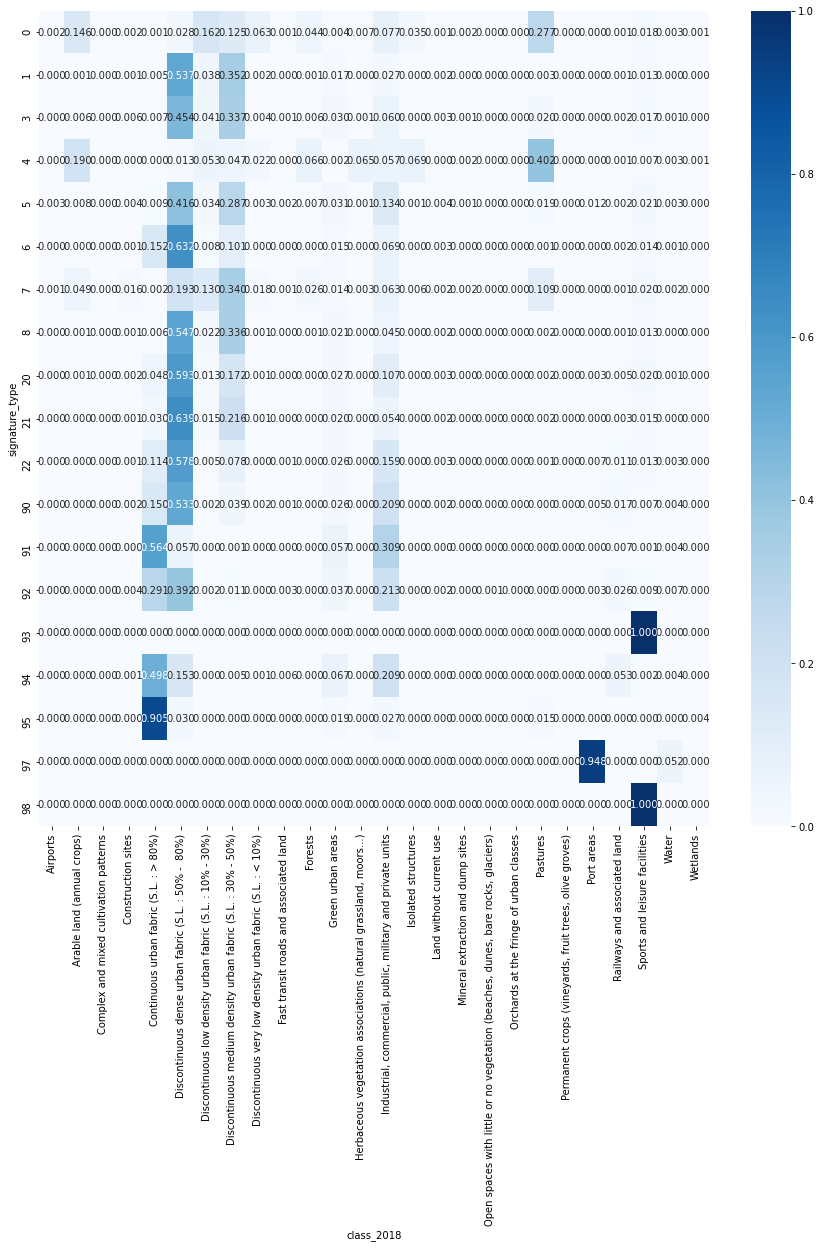

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(crosstab.divide(crosstab.sum(axis=1), axis=0).astype('float'), cmap="Blues", annot=True, fmt='.3f',)

In [37]:
cramers_v(crosstab)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.18601133182588733